<font size="30">---------------</font>
<font size="30">Data processing</font>
<font size="30">---------------</font>

<font size="30">1.0 Prepare data</font>

In [1]:
from pymongo import MongoClient

try: 
    client = MongoClient()
    print("Connected successfully!!!") 
except:
    print("Could not connect to MongoDB") 

db = client.job_advert_db #select database
collection = db.job_advert #select collection to insert

Connected successfully!!!


In [2]:
 from bson.json_util import dumps

In [46]:
job_advert_collection = collection.find({})
print("Amount of data collected:" , job_advert_collection.count())

job_adverts = []

for ja in job_advert_collection:
    job_adverts.append(ja['desc'])

C:\Users\uSER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


Amount of data collected: 4827


<font size="30">2.0 Data Preprocessing</font>

In [35]:
import re, string, unicodedata
import nltk
import contractions #expand the contractions "you're -> you are"
import inflect #convert plural to singular nouns
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords #filter english words "is", "this", "there", etc.
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import tqdm

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

2.1 Denoise Job Descriptions

In [38]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    processed_text = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        text = strip_html(t)
        text = remove_between_square_brackets(t)
        processed_text.append(text)
        pbar.update(1)
    pbar.close()
    return processed_text

In [39]:
job_adverts = denoise_text(job_adverts)

100%|████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:00<00:00, 8801.09it/s]


2.2 Replace contractions in string

In [47]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    text_arr = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        t = contractions.fix(t)
        text_arr.append(t)
        pbar.update(1)
    pbar.close()
    return text_arr

In [48]:
job_adverts = replace_contractions(job_adverts)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:52<00:00, 91.18it/s]


In [49]:
len(job_adverts)
print(job_adverts[:2])

['Leading Local EnterpriseUnderstand current processes and valuable outcomesAble to structure a large amount of information within a process frameworkJob scopeMapping/Reviewing existing business processes and “re-imagine” improved ones by maximizing customer value while minimizing waste and incorporating automation.Facilitate/lead process workshops that involve eliciting process requirements and liaising with usersAbility to interpret business requirements into digital solution.Create project plans that contain project goals, milestones, and resourcesMonitor, measure and provide feedback on process performanceLiaise with management to coordinate process improvement project activitiesRequirements:Enjoys variety at work as this is a wide-ranging role immersing in a variety of different projects, and able see the big picture.Work with other business teams and Digital Department to figure out the best way to design new processes and solve process-related problems.Strong analytical backgrou

2.3 Tokenization

In [50]:
temp_arr = []
pbar = tqdm.tqdm(total=len(job_adverts))
for ja in job_adverts:
    temp_arr.append(nltk.word_tokenize(ja))
    pbar.update(1)
job_adverts = temp_arr
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:20<00:00, 235.39it/s]


In [51]:
len(job_adverts)
print(job_adverts[:2])

[['Leading', 'Local', 'EnterpriseUnderstand', 'current', 'processes', 'and', 'valuable', 'outcomesAble', 'to', 'structure', 'a', 'large', 'amount', 'of', 'information', 'within', 'a', 'process', 'frameworkJob', 'scopeMapping/Reviewing', 'existing', 'business', 'processes', 'and', '“', 're-imagine', '”', 'improved', 'ones', 'by', 'maximizing', 'customer', 'value', 'while', 'minimizing', 'waste', 'and', 'incorporating', 'automation.Facilitate/lead', 'process', 'workshops', 'that', 'involve', 'eliciting', 'process', 'requirements', 'and', 'liaising', 'with', 'usersAbility', 'to', 'interpret', 'business', 'requirements', 'into', 'digital', 'solution.Create', 'project', 'plans', 'that', 'contain', 'project', 'goals', ',', 'milestones', ',', 'and', 'resourcesMonitor', ',', 'measure', 'and', 'provide', 'feedback', 'on', 'process', 'performanceLiaise', 'with', 'management', 'to', 'coordinate', 'process', 'improvement', 'project', 'activitiesRequirements', ':', 'Enjoys', 'variety', 'at', 'work'

2.4 Normalization ((1) stemming, (2) lemmatization, and (3) everything else)

In [52]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    pbar = tqdm.tqdm(total=len(words))
    word_arr = []
    for word in words:
        word = remove_non_ascii(word)
        word = to_lowercase(word)
        word = remove_punctuation(word)
        word = replace_numbers(word)
        word = remove_stopwords(word)
        word_arr.append(word)
        pbar.update(1)
    pbar.close()
    return word_arr

In [53]:
job_adverts = normalize(job_adverts)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [10:32<00:00, 10.88it/s]


In [54]:
len(job_adverts)
print(job_adverts[:2])

[['leading', 'local', 'enterpriseunderstand', 'current', 'processes', 'valuable', 'outcomesable', 'structure', 'large', 'amount', 'information', 'within', 'process', 'frameworkjob', 'scopemappingreviewing', 'existing', 'business', 'processes', 'reimagine', 'improved', 'ones', 'maximizing', 'customer', 'value', 'minimizing', 'waste', 'incorporating', 'automationfacilitatelead', 'process', 'workshops', 'involve', 'eliciting', 'process', 'requirements', 'liaising', 'usersability', 'interpret', 'business', 'requirements', 'digital', 'solutioncreate', 'project', 'plans', 'contain', 'project', 'goals', 'milestones', 'resourcesmonitor', 'measure', 'provide', 'feedback', 'process', 'performanceliaise', 'management', 'coordinate', 'process', 'improvement', 'project', 'activitiesrequirements', 'enjoys', 'variety', 'work', 'wideranging', 'role', 'immersing', 'variety', 'different', 'projects', 'able', 'see', 'big', 'picturework', 'business', 'teams', 'digital', 'department', 'figure', 'best', 'wa

Run this to backup data variable

In [ ]:
#import pickle
#with open('job_advert_variable_dump', 'wb') as f:
#    pickle.dump(job_adverts, f)

Run this to load data variable

In [1]:
import pickle
job_adverts = []
with open('job_advert_variable_dump', 'rb') as f:
    job_adverts = pickle.load(f)
len(job_adverts)

4827

<font size="30">3.0 Data Clustering</font>

3.1 Convert to numerical data

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)  
x = vectorizer.fit_transform(job_adverts)
print("shape : ", x.shape)

C:\Users\uSER\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


shape :  (4827, 41977)


3.2 Finding K with Elbow method

Initialization complete
Iteration  0, inertia 9533.717
Iteration  1, inertia 4598.054
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 9035.154
Iteration  1, inertia 4598.054
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 9131.859
Iteration  1, inertia 4598.054
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 9036.156
Iteration  1, inertia 4598.054
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 9131.913
Iteration  1, inertia 4598.054
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 9090.232
Iteration  1, inertia 4598.054
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.268

Iteration 41, inertia 4538.765
Iteration 42, inertia 4538.734
Iteration 43, inertia 4538.716
Iteration 44, inertia 4538.682
Iteration 45, inertia 4538.646
Iteration 46, inertia 4538.624
Iteration 47, inertia 4538.609
Iteration 48, inertia 4538.604
Iteration 49, inertia 4538.600
Iteration 50, inertia 4538.594
Iteration 51, inertia 4538.583
Iteration 52, inertia 4538.574
Iteration 53, inertia 4538.567
Iteration 54, inertia 4538.565
Iteration 55, inertia 4538.557
Converged at iteration 55: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8998.985
Iteration  1, inertia 4557.643
Iteration  2, inertia 4546.994
Iteration  3, inertia 4543.523
Iteration  4, inertia 4542.535
Iteration  5, inertia 4542.012
Iteration  6, inertia 4541.672
Iteration  7, inertia 4541.356
Iteration  8, inertia 4540.858
Iteration  9, inertia 4540.231
Iteration 10, inertia 4539.708
Iteration 11, inertia 4539.304
Iteration 12, inertia 4538.831
Iteration 13, inertia 453

Iteration 21, inertia 4476.110
Iteration 22, inertia 4476.089
Iteration 23, inertia 4476.071
Iteration 24, inertia 4476.065
Iteration 25, inertia 4476.057
Iteration 26, inertia 4476.043
Iteration 27, inertia 4476.033
Iteration 28, inertia 4476.024
Iteration 29, inertia 4476.013
Iteration 30, inertia 4476.008
Iteration 31, inertia 4476.001
Iteration 32, inertia 4475.990
Iteration 33, inertia 4475.986
Iteration 34, inertia 4475.985
Iteration 35, inertia 4475.977
Iteration 36, inertia 4475.976
Converged at iteration 36: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8480.427
Iteration  1, inertia 4532.468
Iteration  2, inertia 4500.403
Iteration  3, inertia 4488.672
Iteration  4, inertia 4477.052
Iteration  5, inertia 4471.885
Iteration  6, inertia 4470.953
Iteration  7, inertia 4470.672
Iteration  8, inertia 4470.433
Iteration  9, inertia 4470.356
Iteration 10, inertia 4470.324
Iteration 11, inertia 4470.309
Iteration 12, inertia 447

Iteration 31, inertia 4452.227
Iteration 32, inertia 4452.200
Iteration 33, inertia 4452.172
Iteration 34, inertia 4452.150
Iteration 35, inertia 4452.144
Converged at iteration 35: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8710.669
Iteration  1, inertia 4520.091
Iteration  2, inertia 4493.142
Iteration  3, inertia 4483.743
Iteration  4, inertia 4477.181
Iteration  5, inertia 4469.448
Iteration  6, inertia 4465.283
Iteration  7, inertia 4463.521
Iteration  8, inertia 4462.533
Iteration  9, inertia 4461.716
Iteration 10, inertia 4460.651
Iteration 11, inertia 4459.785
Iteration 12, inertia 4458.752
Iteration 13, inertia 4458.005
Iteration 14, inertia 4457.349
Iteration 15, inertia 4456.872
Iteration 16, inertia 4456.389
Iteration 17, inertia 4456.074
Iteration 18, inertia 4455.809
Iteration 19, inertia 4455.411
Iteration 20, inertia 4454.907
Iteration 21, inertia 4454.387
Iteration 22, inertia 4453.422
Iteration 23, inertia 445

Iteration 27, inertia 4446.433
Iteration 28, inertia 4446.370
Iteration 29, inertia 4446.348
Iteration 30, inertia 4446.346
Iteration 31, inertia 4446.344
Iteration 32, inertia 4446.343
Converged at iteration 32: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8530.468
Iteration  1, inertia 4507.547
Iteration  2, inertia 4488.696
Iteration  3, inertia 4480.036
Iteration  4, inertia 4473.742
Iteration  5, inertia 4469.981
Iteration  6, inertia 4466.216
Iteration  7, inertia 4458.533
Iteration  8, inertia 4447.865
Iteration  9, inertia 4444.021
Iteration 10, inertia 4443.211
Iteration 11, inertia 4442.787
Iteration 12, inertia 4442.548
Iteration 13, inertia 4442.439
Iteration 14, inertia 4442.375
Iteration 15, inertia 4442.333
Iteration 16, inertia 4442.304
Iteration 17, inertia 4442.296
Iteration 18, inertia 4442.290
Iteration 19, inertia 4442.281
Iteration 20, inertia 4442.278
Converged at iteration 20: center shift 0.000000e+00 wit

Iteration  1, inertia 4455.608
Iteration  2, inertia 4435.086
Iteration  3, inertia 4429.314
Iteration  4, inertia 4425.382
Iteration  5, inertia 4422.729
Iteration  6, inertia 4419.273
Iteration  7, inertia 4415.349
Iteration  8, inertia 4411.043
Iteration  9, inertia 4407.456
Iteration 10, inertia 4404.571
Iteration 11, inertia 4403.715
Iteration 12, inertia 4403.269
Iteration 13, inertia 4402.799
Iteration 14, inertia 4402.553
Iteration 15, inertia 4402.347
Iteration 16, inertia 4401.976
Iteration 17, inertia 4401.665
Iteration 18, inertia 4401.413
Iteration 19, inertia 4401.114
Iteration 20, inertia 4400.853
Iteration 21, inertia 4400.595
Iteration 22, inertia 4400.088
Iteration 23, inertia 4399.902
Iteration 24, inertia 4399.547
Iteration 25, inertia 4399.242
Iteration 26, inertia 4399.103
Iteration 27, inertia 4398.616
Iteration 28, inertia 4396.110
Iteration 29, inertia 4394.508
Iteration 30, inertia 4394.490
Iteration 31, inertia 4394.484
Iteration 32, inertia 4394.481
Iteratio

Iteration  5, inertia 4392.970
Iteration  6, inertia 4391.126
Iteration  7, inertia 4389.250
Iteration  8, inertia 4385.759
Iteration  9, inertia 4378.943
Iteration 10, inertia 4376.409
Iteration 11, inertia 4374.007
Iteration 12, inertia 4372.751
Iteration 13, inertia 4371.486
Iteration 14, inertia 4371.313
Iteration 15, inertia 4371.215
Iteration 16, inertia 4371.167
Iteration 17, inertia 4371.145
Iteration 18, inertia 4371.137
Iteration 19, inertia 4371.129
Iteration 20, inertia 4371.107
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8389.458
Iteration  1, inertia 4450.070
Iteration  2, inertia 4421.424
Iteration  3, inertia 4409.508
Iteration  4, inertia 4402.146
Iteration  5, inertia 4395.719
Iteration  6, inertia 4387.794
Iteration  7, inertia 4383.605
Iteration  8, inertia 4380.865
Iteration  9, inertia 4379.150
Iteration 10, inertia 4378.031
Iteration 11, inertia 4377.198
Iteration 12, inertia 437

Iteration 13, inertia 4351.635
Iteration 14, inertia 4351.565
Iteration 15, inertia 4351.525
Iteration 16, inertia 4351.487
Iteration 17, inertia 4351.464
Iteration 18, inertia 4351.435
Iteration 19, inertia 4351.412
Iteration 20, inertia 4351.383
Iteration 21, inertia 4351.370
Iteration 22, inertia 4351.367
Converged at iteration 22: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8313.100
Iteration  1, inertia 4426.408
Iteration  2, inertia 4391.034
Iteration  3, inertia 4380.070
Iteration  4, inertia 4374.816
Iteration  5, inertia 4370.416
Iteration  6, inertia 4364.440
Iteration  7, inertia 4360.086
Iteration  8, inertia 4356.634
Iteration  9, inertia 4354.814
Iteration 10, inertia 4354.507
Iteration 11, inertia 4354.353
Iteration 12, inertia 4354.288
Iteration 13, inertia 4354.247
Iteration 14, inertia 4354.238
Iteration 15, inertia 4354.234
Iteration 16, inertia 4354.232
Converged at iteration 16: center shift 0.000000e+00 wit

Converged at iteration 28: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8246.227
Iteration  1, inertia 4430.040
Iteration  2, inertia 4401.061
Iteration  3, inertia 4385.072
Iteration  4, inertia 4367.011
Iteration  5, inertia 4360.041
Iteration  6, inertia 4358.593
Iteration  7, inertia 4357.211
Iteration  8, inertia 4356.502
Iteration  9, inertia 4355.878
Iteration 10, inertia 4354.552
Iteration 11, inertia 4352.243
Iteration 12, inertia 4350.096
Iteration 13, inertia 4349.626
Iteration 14, inertia 4349.578
Iteration 15, inertia 4349.556
Iteration 16, inertia 4349.533
Iteration 17, inertia 4349.519
Iteration 18, inertia 4349.503
Iteration 19, inertia 4349.490
Iteration 20, inertia 4349.484
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8304.620
Iteration  1, inertia 4395.965
Iteration  2, inertia 4364.154
Iteration  3, inertia 4354.939
Iteration  

Iteration  8, inertia 4321.583
Iteration  9, inertia 4320.201
Iteration 10, inertia 4319.357
Iteration 11, inertia 4318.431
Iteration 12, inertia 4318.173
Iteration 13, inertia 4317.864
Iteration 14, inertia 4317.689
Iteration 15, inertia 4317.507
Iteration 16, inertia 4317.419
Iteration 17, inertia 4317.385
Iteration 18, inertia 4317.376
Iteration 19, inertia 4317.367
Iteration 20, inertia 4317.352
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8395.544
Iteration  1, inertia 4418.372
Iteration  2, inertia 4365.709
Iteration  3, inertia 4346.630
Iteration  4, inertia 4338.130
Iteration  5, inertia 4333.327
Iteration  6, inertia 4329.990
Iteration  7, inertia 4327.515
Iteration  8, inertia 4325.722
Iteration  9, inertia 4323.912
Iteration 10, inertia 4322.432
Iteration 11, inertia 4319.418
Iteration 12, inertia 4315.194
Iteration 13, inertia 4314.251
Iteration 14, inertia 4313.881
Iteration 15, inertia 431

Iteration 16, inertia 4308.988
Iteration 17, inertia 4308.953
Iteration 18, inertia 4308.928
Iteration 19, inertia 4308.889
Iteration 20, inertia 4308.877
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8175.174
Iteration  1, inertia 4388.399
Iteration  2, inertia 4361.447
Iteration  3, inertia 4341.641
Iteration  4, inertia 4329.444
Iteration  5, inertia 4323.393
Iteration  6, inertia 4319.367
Iteration  7, inertia 4315.818
Iteration  8, inertia 4314.103
Iteration  9, inertia 4312.788
Iteration 10, inertia 4311.845
Iteration 11, inertia 4311.388
Iteration 12, inertia 4311.010
Iteration 13, inertia 4310.261
Iteration 14, inertia 4309.976
Iteration 15, inertia 4309.612
Iteration 16, inertia 4309.460
Iteration 17, inertia 4309.353
Iteration 18, inertia 4309.070
Iteration 19, inertia 4308.721
Iteration 20, inertia 4308.410
Iteration 21, inertia 4308.089
Iteration 22, inertia 4307.997
Iteration 23, inertia 430

Iteration 40, inertia 4294.623
Iteration 41, inertia 4294.620
Converged at iteration 41: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8168.323
Iteration  1, inertia 4379.006
Iteration  2, inertia 4340.761
Iteration  3, inertia 4325.382
Iteration  4, inertia 4318.117
Iteration  5, inertia 4313.416
Iteration  6, inertia 4309.099
Iteration  7, inertia 4305.919
Iteration  8, inertia 4304.083
Iteration  9, inertia 4303.040
Iteration 10, inertia 4302.457
Iteration 11, inertia 4301.965
Iteration 12, inertia 4301.726
Iteration 13, inertia 4301.494
Iteration 14, inertia 4301.327
Iteration 15, inertia 4301.186
Iteration 16, inertia 4301.015
Iteration 17, inertia 4300.778
Iteration 18, inertia 4299.887
Iteration 19, inertia 4298.767
Iteration 20, inertia 4298.560
Iteration 21, inertia 4298.449
Iteration 22, inertia 4298.385
Iteration 23, inertia 4298.359
Iteration 24, inertia 4298.280
Iteration 25, inertia 4298.262
Converged at iteration 25

Iteration 11, inertia 4284.883
Iteration 12, inertia 4284.698
Iteration 13, inertia 4284.610
Iteration 14, inertia 4284.516
Iteration 15, inertia 4284.396
Iteration 16, inertia 4284.333
Iteration 17, inertia 4284.267
Iteration 18, inertia 4284.223
Iteration 19, inertia 4284.178
Iteration 20, inertia 4284.134
Iteration 21, inertia 4284.026
Iteration 22, inertia 4283.937
Iteration 23, inertia 4283.867
Iteration 24, inertia 4283.816
Iteration 25, inertia 4283.715
Iteration 26, inertia 4283.631
Iteration 27, inertia 4283.507
Iteration 28, inertia 4283.451
Iteration 29, inertia 4283.354
Iteration 30, inertia 4283.192
Iteration 31, inertia 4282.998
Iteration 32, inertia 4282.699
Iteration 33, inertia 4282.342
Iteration 34, inertia 4281.975
Iteration 35, inertia 4281.474
Iteration 36, inertia 4280.622
Iteration 37, inertia 4279.625
Iteration 38, inertia 4279.040
Iteration 39, inertia 4278.857
Iteration 40, inertia 4278.768
Iteration 41, inertia 4278.737
Iteration 42, inertia 4278.717
Iteratio

Iteration  1, inertia 4335.553
Iteration  2, inertia 4311.823
Iteration  3, inertia 4300.956
Iteration  4, inertia 4294.209
Iteration  5, inertia 4291.018
Iteration  6, inertia 4289.079
Iteration  7, inertia 4287.853
Iteration  8, inertia 4287.080
Iteration  9, inertia 4286.460
Iteration 10, inertia 4285.593
Iteration 11, inertia 4285.151
Iteration 12, inertia 4285.018
Iteration 13, inertia 4284.932
Iteration 14, inertia 4284.770
Iteration 15, inertia 4284.647
Iteration 16, inertia 4284.535
Iteration 17, inertia 4284.269
Iteration 18, inertia 4284.077
Iteration 19, inertia 4283.891
Iteration 20, inertia 4283.834
Iteration 21, inertia 4283.768
Iteration 22, inertia 4283.733
Iteration 23, inertia 4283.722
Iteration 24, inertia 4283.695
Iteration 25, inertia 4283.664
Iteration 26, inertia 4283.649
Iteration 27, inertia 4283.608
Iteration 28, inertia 4283.581
Iteration 29, inertia 4283.542
Iteration 30, inertia 4283.503
Iteration 31, inertia 4283.423
Iteration 32, inertia 4283.378
Iteratio

Iteration 12, inertia 4260.915
Iteration 13, inertia 4260.422
Iteration 14, inertia 4259.623
Iteration 15, inertia 4258.168
Iteration 16, inertia 4256.807
Iteration 17, inertia 4256.602
Iteration 18, inertia 4256.386
Iteration 19, inertia 4256.162
Iteration 20, inertia 4256.010
Iteration 21, inertia 4255.697
Iteration 22, inertia 4255.457
Iteration 23, inertia 4255.162
Iteration 24, inertia 4254.680
Iteration 25, inertia 4254.520
Iteration 26, inertia 4254.472
Iteration 27, inertia 4254.423
Converged at iteration 27: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8043.816
Iteration  1, inertia 4325.016
Iteration  2, inertia 4293.260
Iteration  3, inertia 4273.480
Iteration  4, inertia 4267.527
Iteration  5, inertia 4265.046
Iteration  6, inertia 4263.487
Iteration  7, inertia 4262.769
Iteration  8, inertia 4262.281
Iteration  9, inertia 4262.016
Iteration 10, inertia 4261.872
Iteration 11, inertia 4261.792
Iteration 12, inertia 426

Iteration  9, inertia 4270.355
Iteration 10, inertia 4269.900
Iteration 11, inertia 4269.476
Iteration 12, inertia 4268.907
Iteration 13, inertia 4268.513
Iteration 14, inertia 4267.987
Iteration 15, inertia 4267.469
Iteration 16, inertia 4266.799
Iteration 17, inertia 4266.299
Iteration 18, inertia 4265.877
Iteration 19, inertia 4265.509
Iteration 20, inertia 4265.143
Iteration 21, inertia 4264.753
Iteration 22, inertia 4264.515
Iteration 23, inertia 4264.238
Iteration 24, inertia 4263.933
Iteration 25, inertia 4263.625
Iteration 26, inertia 4263.283
Iteration 27, inertia 4263.003
Iteration 28, inertia 4262.730
Iteration 29, inertia 4262.500
Iteration 30, inertia 4262.295
Iteration 31, inertia 4262.075
Iteration 32, inertia 4261.778
Iteration 33, inertia 4261.308
Iteration 34, inertia 4260.452
Iteration 35, inertia 4258.433
Iteration 36, inertia 4254.923
Iteration 37, inertia 4252.091
Iteration 38, inertia 4251.290
Iteration 39, inertia 4250.805
Iteration 40, inertia 4250.395
Iteratio

Iteration  8, inertia 4258.036
Iteration  9, inertia 4257.596
Iteration 10, inertia 4257.280
Iteration 11, inertia 4257.033
Iteration 12, inertia 4256.703
Iteration 13, inertia 4256.336
Iteration 14, inertia 4256.091
Iteration 15, inertia 4255.948
Iteration 16, inertia 4255.791
Iteration 17, inertia 4255.678
Iteration 18, inertia 4255.589
Iteration 19, inertia 4255.541
Iteration 20, inertia 4255.470
Iteration 21, inertia 4255.400
Iteration 22, inertia 4255.326
Iteration 23, inertia 4255.247
Iteration 24, inertia 4255.207
Iteration 25, inertia 4255.172
Iteration 26, inertia 4255.020
Iteration 27, inertia 4254.861
Iteration 28, inertia 4254.658
Iteration 29, inertia 4254.351
Iteration 30, inertia 4253.944
Iteration 31, inertia 4253.737
Iteration 32, inertia 4253.569
Iteration 33, inertia 4253.357
Iteration 34, inertia 4253.155
Iteration 35, inertia 4252.990
Iteration 36, inertia 4252.903
Iteration 37, inertia 4252.790
Iteration 38, inertia 4252.723
Iteration 39, inertia 4252.669
Iteratio

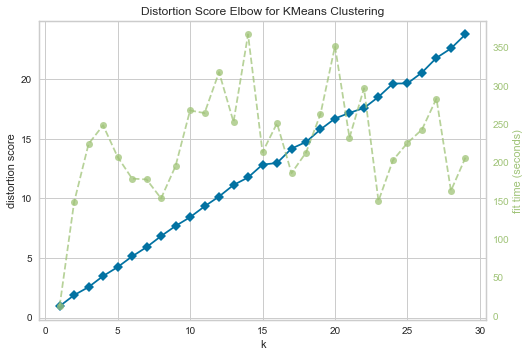

In [73]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++',max_iter=300,n_init=10,random_state=0, verbose=True)
visualizer = KElbowVisualizer(kmeans, k=(1,30))

visualizer.fit(x)    # Fit the data to the visualizer
visualizer.poof(outpath="elbow(K=30).png")

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++',max_iter=100,n_init=10,random_state=0, verbose=True)
visualizer = KElbowVisualizer(kmeans, metric='silhouette', k=(2,30))

visualizer.fit(x)    # Fit the data to the visualizer
visualizer.poof()

Initialization complete
Iteration  0, inertia 9074.822
Iteration  1, inertia 4588.082
Iteration  2, inertia 4575.603
Iteration  3, inertia 4573.797
Iteration  4, inertia 4571.938
Iteration  5, inertia 4570.488
Iteration  6, inertia 4569.431
Iteration  7, inertia 4568.791
Iteration  8, inertia 4568.472
Iteration  9, inertia 4568.228
Iteration 10, inertia 4568.172
Iteration 11, inertia 4568.140
Iteration 12, inertia 4568.115
Iteration 13, inertia 4568.061
Iteration 14, inertia 4567.855
Iteration 15, inertia 4567.549
Iteration 16, inertia 4567.005
Iteration 17, inertia 4566.879
Iteration 18, inertia 4566.833
Iteration 19, inertia 4566.817
Iteration 20, inertia 4566.802
Iteration 21, inertia 4566.782
Iteration 22, inertia 4566.767
Iteration 23, inertia 4566.766
Converged at iteration 23: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8880.105
Iteration  1, inertia 4581.609
Iteration  2, inertia 4569.672
Iteration  3, inertia 4568.636
I

Iteration 12, inertia 4526.116
Iteration 13, inertia 4526.109
Iteration 14, inertia 4526.095
Iteration 15, inertia 4526.079
Iteration 16, inertia 4526.074
Iteration 17, inertia 4526.070
Iteration 18, inertia 4526.065
Iteration 19, inertia 4526.062
Iteration 20, inertia 4526.060
Iteration 21, inertia 4526.060
Converged at iteration 21: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8854.185
Iteration  1, inertia 4554.221
Iteration  2, inertia 4541.770
Iteration  3, inertia 4539.621
Iteration  4, inertia 4539.206
Iteration  5, inertia 4539.035
Iteration  6, inertia 4538.955
Iteration  7, inertia 4538.929
Iteration  8, inertia 4538.920
Iteration  9, inertia 4538.912
Iteration 10, inertia 4538.910
Iteration 11, inertia 4538.899
Iteration 12, inertia 4538.894
Iteration 13, inertia 4538.890
Iteration 14, inertia 4538.889
Iteration 15, inertia 4538.888
Converged at iteration 15: center shift 0.000000e+00 within tolerance 2.268293e-09
Init

Iteration 26, inertia 4498.815
Iteration 27, inertia 4498.797
Iteration 28, inertia 4498.771
Iteration 29, inertia 4498.737
Iteration 30, inertia 4498.486
Iteration 31, inertia 4498.279
Iteration 32, inertia 4498.196
Iteration 33, inertia 4498.123
Iteration 34, inertia 4498.078
Iteration 35, inertia 4498.062
Iteration 36, inertia 4498.053
Iteration 37, inertia 4498.050
Converged at iteration 37: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8525.695
Iteration  1, inertia 4542.284
Iteration  2, inertia 4527.501
Iteration  3, inertia 4523.917
Iteration  4, inertia 4522.114
Iteration  5, inertia 4520.160
Iteration  6, inertia 4518.551
Iteration  7, inertia 4518.052
Iteration  8, inertia 4517.786
Iteration  9, inertia 4517.308
Iteration 10, inertia 4516.958
Iteration 11, inertia 4516.784
Iteration 12, inertia 4516.691
Iteration 13, inertia 4516.627
Iteration 14, inertia 4516.537
Iteration 15, inertia 4516.486
Iteration 16, inertia 451

3.3 Use Optimal K-Value to run clustering

load backup model

In [6]:
with open('kmeans_model(K=15)', 'rb') as f:
    kmeans = pickle.load(f)

In [3]:
from sklearn.cluster import KMeans
true_k = 15

kmeans = KMeans(n_clusters=true_k,init='k-means++',max_iter=100,n_init=10,random_state=0, verbose=True)
kmeans.fit(x)

with open('kmeans_model(K=15)', 'wb') as f:
    pickle.dump(kmeans, f)

Initialization complete
Iteration  0, inertia 8243.222
Iteration  1, inertia 4398.440
Iteration  2, inertia 4366.188
Iteration  3, inertia 4354.124
Iteration  4, inertia 4347.938
Iteration  5, inertia 4344.116
Iteration  6, inertia 4341.888
Iteration  7, inertia 4340.725
Iteration  8, inertia 4340.013
Iteration  9, inertia 4339.460
Iteration 10, inertia 4339.151
Iteration 11, inertia 4338.847
Iteration 12, inertia 4338.657
Iteration 13, inertia 4338.434
Iteration 14, inertia 4338.185
Iteration 15, inertia 4337.977
Iteration 16, inertia 4337.810
Iteration 17, inertia 4337.527
Iteration 18, inertia 4337.170
Iteration 19, inertia 4337.002
Iteration 20, inertia 4336.938
Iteration 21, inertia 4336.924
Iteration 22, inertia 4336.906
Iteration 23, inertia 4336.845
Iteration 24, inertia 4336.825
Iteration 25, inertia 4336.806
Converged at iteration 25: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 8396.686
Iteration  1, inertia 4424.853
I

Iteration  1, inertia 4421.187
Iteration  2, inertia 4390.751
Iteration  3, inertia 4374.297
Iteration  4, inertia 4364.145
Iteration  5, inertia 4358.566
Iteration  6, inertia 4354.996
Iteration  7, inertia 4353.252
Iteration  8, inertia 4351.828
Iteration  9, inertia 4350.802
Iteration 10, inertia 4350.035
Iteration 11, inertia 4349.383
Iteration 12, inertia 4348.921
Iteration 13, inertia 4348.570
Iteration 14, inertia 4348.338
Iteration 15, inertia 4348.131
Iteration 16, inertia 4347.907
Iteration 17, inertia 4347.664
Iteration 18, inertia 4347.455
Iteration 19, inertia 4347.311
Iteration 20, inertia 4347.100
Iteration 21, inertia 4346.851
Iteration 22, inertia 4346.623
Iteration 23, inertia 4346.432
Iteration 24, inertia 4346.348
Iteration 25, inertia 4346.257
Iteration 26, inertia 4346.211
Iteration 27, inertia 4346.137
Iteration 28, inertia 4346.054
Iteration 29, inertia 4345.974
Iteration 30, inertia 4345.902
Iteration 31, inertia 4345.834
Iteration 32, inertia 4345.809
Iteratio

NameError: name 'clf' is not defined

In [10]:
from sklearn.cluster import KMeans
true_k = 24

kmeans = KMeans(n_clusters=true_k,init='k-means++',max_iter=100,n_init=10,random_state=0, verbose=True)
kmeans.fit(x)

with open('kmeans_model(K=24)', 'wb') as f:
    pickle.dump(kmeans, f)

Initialization complete
Iteration  0, inertia 8076.388
Iteration  1, inertia 4362.549
Iteration  2, inertia 4328.644
Iteration  3, inertia 4311.171
Iteration  4, inertia 4300.710
Iteration  5, inertia 4294.652
Iteration  6, inertia 4288.178
Iteration  7, inertia 4282.944
Iteration  8, inertia 4282.186
Iteration  9, inertia 4281.829
Iteration 10, inertia 4281.615
Iteration 11, inertia 4281.436
Iteration 12, inertia 4281.150
Iteration 13, inertia 4280.619
Iteration 14, inertia 4279.679
Iteration 15, inertia 4278.968
Iteration 16, inertia 4277.950
Iteration 17, inertia 4277.058
Iteration 18, inertia 4276.490
Iteration 19, inertia 4275.575
Iteration 20, inertia 4274.540
Iteration 21, inertia 4273.624
Iteration 22, inertia 4273.402
Iteration 23, inertia 4273.098
Iteration 24, inertia 4272.999
Iteration 25, inertia 4272.934
Iteration 26, inertia 4272.833
Iteration 27, inertia 4272.770
Iteration 28, inertia 4272.738
Iteration 29, inertia 4272.721
Iteration 30, inertia 4272.701
Iteration 31, i

Iteration  8, inertia 4281.118
Iteration  9, inertia 4279.604
Iteration 10, inertia 4278.860
Iteration 11, inertia 4278.297
Iteration 12, inertia 4277.481
Iteration 13, inertia 4276.631
Iteration 14, inertia 4275.385
Iteration 15, inertia 4274.870
Iteration 16, inertia 4274.351
Iteration 17, inertia 4273.853
Iteration 18, inertia 4273.521
Iteration 19, inertia 4273.334
Iteration 20, inertia 4273.144
Iteration 21, inertia 4272.948
Iteration 22, inertia 4272.704
Iteration 23, inertia 4272.476
Iteration 24, inertia 4272.261
Iteration 25, inertia 4272.074
Iteration 26, inertia 4271.850
Iteration 27, inertia 4271.694
Iteration 28, inertia 4271.601
Iteration 29, inertia 4271.530
Iteration 30, inertia 4271.414
Iteration 31, inertia 4271.327
Iteration 32, inertia 4271.230
Iteration 33, inertia 4271.139
Iteration 34, inertia 4271.071
Iteration 35, inertia 4271.017
Iteration 36, inertia 4270.943
Iteration 37, inertia 4270.868
Iteration 38, inertia 4270.827
Iteration 39, inertia 4270.807
Iteratio

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=24, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=True)

In [8]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print('Cluster %d:' % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])

Cluster 0:
 data
 analytics
 business
 experience
 big
 machine
 learning
 team
 etl
 intelligence
 models
 analysis
 management
 hadoop
 skills
Cluster 1:
 network
 infrastructure
 cloud
 security
 experience
 server
 management
 support
 storage
 systems
 knowledge
 service
 administration
 cisco
 services
Cluster 2:
 java
 spring
 experience
 oracle
 web
 development
 sql
 hibernate
 exp
 net
 server
 application
 knowledge
 framework
 design
Cluster 3:
 project
 management
 projects
 manage
 team
 experience
 business
 work
 requirements
 budget
 ensure
 delivery
 deliverables
 manager
 schedule
Cluster 4:
 business
 design
 requirements
 development
 technical
 software
 experience
 project
 work
 application
 solutions
 user
 team
 support
 skills
Cluster 5:
 status
 experience
 equal
 gender
 employment
 opportunity
 disability
 sitecore
 team
 work
 business
 autodesk
 race
 origin
 religion
Cluster 6:
 infotech
 pleased
 openings
 greetings
 inform
 regarding
 infotechposition

In [24]:
words = vectorizer.get_feature_names()
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : data, analytics, business, experience, big, machine, learning, team, etl, intelligence, models, analysis, management, hadoop, skills, solutions, bi, science, work, tools, sql, requirements, understanding, development, architecture
1 : network, infrastructure, cloud, security, experience, server, management, support, storage, systems, knowledge, service, administration, cisco, services, windows, servers, technical, backup, database, configuration, linux, skills, vmware, troubleshooting
2 : java, spring, experience, oracle, web, development, sql, hibernate, exp, net, server, application, knowledge, framework, design, j2ee, years, hands, database, developer, software, programming, mvc, good, struts
3 : project, management, projects, manage, team, experience, business, work, requirements, budget, ensure, delivery, deliverables, manager, schedule, scope, skills, plan, development, managing, stakeholders, implementation, including, change, communication
4 : business, design, requirements

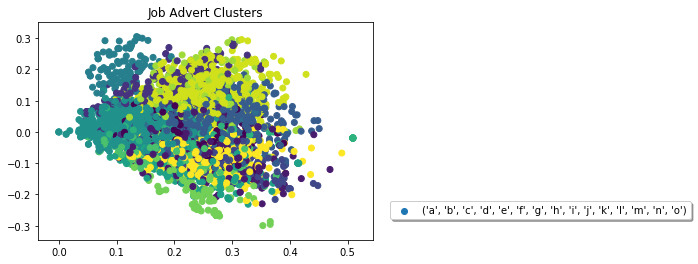

In [59]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(x)
data2D = svd.transform(x)

groups = ("a", "b", "c", "d", "e", "f", "g","h", "i", "j", "k", "l", "m","n","o")

plt.scatter(data2D[:,0], data2D[:, 1], c=kmeans.labels_.tolist(), label=groups)
plt.title("Job Advert Clusters")
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.2), shadow=True)
plt.show()


In [38]:
clusters = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
len(clusters)

15